In [15]:
import itertools
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import tensorflow.contrib.slim as slim
import time
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from dataset import Dataset

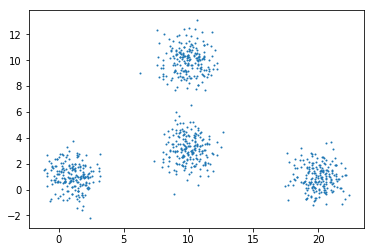

In [2]:
sess = tf.InteractiveSession()
normal = tfd.MultivariateNormalDiag(loc=[0.0, 0.0], scale_diag=[1.0, 1.0])
s1 = [1,1] + sess.run(normal.sample(200))
s2 = [10, 10] + sess.run(normal.sample(200))
s3 = [20, 1] + sess.run(normal.sample(200))
s4 = [10, 3] + sess.run(normal.sample(200))
samples = np.concatenate((s1,s2,s3,s4))
gnd = np.concatenate((np.zeros(200), np.zeros(200)+1,np.zeros(200)+2,np.zeros(200)+3))
plt.scatter(samples[:,0], samples[:,1], s=1)

In [4]:
def inference_network(x, latent_dim, hidden_size):
    """Construct an inference network parametrizing a Gaussian.
    Args:
    x: A batch of MNIST digits.
    latent_dim: The latent dimensionality.
    hidden_size: The size of the neural net hidden layers.
    Returns:
    mu: Mean parameters for the variational family Normal
    sigma: Standard deviation parameters for the variational family Normal
    """
    with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.relu):
        net = slim.fully_connected(x, hidden_size)
        net = slim.fully_connected(net, hidden_size)
        gaussian_params = slim.fully_connected(
            net, latent_dim * 2, activation_fn=None)
    # The mean parameter is unconstrained
    mu = gaussian_params[:, :latent_dim]
    # The standard deviation must be positive. Parametrize with a softplus
    sigma = tf.nn.softplus(gaussian_params[:, latent_dim:])
    return mu, sigma


def generative_network(z, x_dim, hidden_size):
    """Build a generative network parametrizing the likelihood of the data
    Args:
    z: Samples of latent variables
    hidden_size: Size of the hidden state of the neural net
    Returns:
    bernoulli_logits: logits for the Bernoulli likelihood of the data
    """
    with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.relu):
        net = slim.fully_connected(z, hidden_size)
        net = slim.fully_connected(net, hidden_size)
        gaussian_params = slim.fully_connected(net, x_dim * 2, activation_fn=None)
        mu = gaussian_params[:, :x_dim]
        sigma = tf.nn.softplus(gaussian_params[:, x_dim:])
    
    return mu, sigma

In [5]:
latent_dim = 1 #Latent dimensionality of model
x_dim = 2 # dimension of data point
batch_size = 64 #Minibatch size
n_samples = 10 #Number of samples to save
print_every = 10 #Print every n iterations
hidden_size = 200 #Hidden size for neural networks
n_iterations = 1000 #number of iterations

In [6]:
# Input placeholders
with tf.name_scope('data'):
    x = tf.placeholder(tf.float32, [None, x_dim])

with tf.variable_scope('variational'):
    q_mu, q_sigma = inference_network(x=x,
                                      latent_dim=latent_dim,
                                      hidden_size=hidden_size)
    # The variational distribution is a Normal with mean and standard
    # deviation given by the inference network
    q_z = tfd.MultivariateNormalDiag(loc=q_mu, scale_diag=q_sigma)
    assert q_z.reparameterization_type == tfd.FULLY_REPARAMETERIZED

with tf.variable_scope('model'):
    # The likelihood is Bernoulli-distributed with logits given by the
    # generative network
    p_x_given_z_mu, p_x_given_z_sigma = generative_network(z=q_z.sample(), x_dim=x_dim,
                                            hidden_size=hidden_size)
    p_x_given_z = tfd.MultivariateNormalDiag(loc=p_x_given_z_mu, scale_diag=p_x_given_z_sigma)
    posterior_predictive_samples = p_x_given_z.sample()
    
#     Take samples from the prior
with tf.variable_scope('model', reuse=True):
    p_z = tfd.MultivariateNormalDiag(loc=np.zeros(latent_dim, dtype=np.float32),
                               scale_diag=np.ones(latent_dim, dtype=np.float32))

# Build the evidence lower bound (ELBO) or the negative loss
kl = tf.reduce_sum(tfd.kl_divergence(q_z, p_z))
expected_log_likelihood = tf.reduce_sum(p_x_given_z.log_prob(x))

elbo = tf.reduce_sum(expected_log_likelihood - kl)

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

train_op = optimizer.minimize(-elbo)




In [16]:
# Run training
perm = np.random.permutation(np.arange(samples.shape[0]))
samples = samples[perm]
gnd = gnd[perm]
data = Dataset(samples, ratio=0.8)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
t0 = time.time()
elbos = []
vals = []
for i in range(n_iterations):
    # Re-binarize the data at every batch; this improves results
    x_trn = data.next_batch(batch_size=batch_size, roll_over=True)
    sess.run(train_op, {x: x_trn})

    # Print progress and save samples every so often
    if i % print_every == 0:
        np_elbo = sess.run(elbo, {x: x_trn})
        elbos += [-np_elbo]
        val_loss = sess.run(elbo, {x: data.validation_batch()})
        vals += [-val_loss]
        print('Iteration: {0:d} ELBO: {1:.3f} s/iter: {2:.3e}'.format(i,np_elbo / batch_size,(time.time() - t0) / print_every))



/home/drproduck/miniconda3/envs/deep_prob/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Iteration: 0 ELBO: -170.268 s/iter: 9.986e-02
Iteration: 10 ELBO: -35.332 s/iter: 1.104e-01
Iteration: 20 ELBO: -21.730 s/iter: 1.197e-01
Iteration: 30 ELBO: -14.669 s/iter: 1.306e-01
Iteration: 40 ELBO: -11.256 s/iter: 1.396e-01
Iteration: 50 ELBO: -10.259 s/iter: 1.483e-01
Iteration: 60 ELBO: -9.289 s/iter: 1.653e-01
Iteration: 70 ELBO: -8.622 s/iter: 1.826e-01
Iteration: 80 ELBO: -8.279 s/iter: 1.937e-01
Iteration: 90 ELBO: -8.304 s/iter: 2.019e-01
Iteration: 100 ELBO: -7.713 s/iter: 2.090e-01
Iteration: 110 ELBO: -7.429 s/iter: 2.186e-01
Iteration: 120 ELBO: -7.491 s/iter: 2.277e-01
Iteration: 130 ELBO: -7.090 s/iter: 2.350e-01
Iteration: 140 ELBO: -6.982 s/iter: 2.437e-01
Iteration: 150 ELBO: -6.965 s/iter: 2.519e-01
Iteration: 160 ELBO: -6.654 s/iter: 2.607e-01
Iteration: 170 ELBO: -6.701 s/iter: 2.718e-01
Iteration: 180 ELBO: -6.538 s/iter: 2.805e-01
Iteration: 190 ELBO: -6.668 s/iter: 2.903e-01
Iteration: 200 ELBO: -6.441 s/iter: 3.012e-01
Iteration: 210 ELBO: -6.426 s/iter: 3.

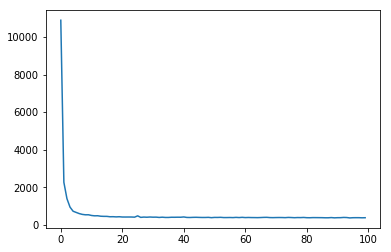

In [17]:
plt.plot(elbos)

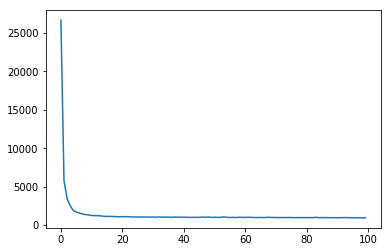

In [18]:
plt.plot(vals)

(160, 1)
(160,)


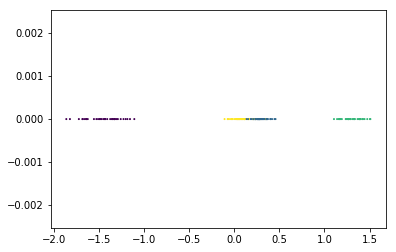

In [19]:
embedding = sess.run(q_mu, {x:data.x_val})
print(embedding.shape)
print(gnd[data.thres:].shape)
plt.scatter(embedding, np.zeros(160), c=gnd[data.thres:],s=1)